## Imports

In [87]:
import re
import logging
import warnings
import plotly
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns


from config import config
from get_offers_by_city import connect
from pandas_profiling import ProfileReport

## NB configs

In [115]:
warnings.filterwarnings('ignore')

SEED = 43

%matplotlib inline
%pylab inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = 18

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)


sns.set()

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 300
pd.options.display.max_columns = 50

Populating the interactive namespace from numpy and matplotlib


## Helper functions

In [127]:
# Function to plot values upside the barplot
def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(float(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

## Connection do DB

In [6]:
conn = connect(config())

query = '''
    SELECT * FROM rent_infos_cleaned
'''

cursor = conn.cursor()
cursor.execute(query)
result = cursor.fetchall()
conn.close()

Connecting to database...
Connection successful


## Load Dataframe

In [7]:
df = pd.DataFrame(result, columns=['offer_id', 'extraction_date', 'lat', 'lng', 'area_m2', 
                                   'furnished','zip_code', 'objectcat', 'rooms', 'build_year', 
                                   'state', 'city','sub_category', 'balcony', 'heat_type', 
                                   'offer_title', 'kitchen','rent_price', 'garden'])

In [8]:
df.head()

,offer_id,extraction_date,lat,lng,area_m2,furnished,zip_code,objectcat,rooms,build_year,state,city,sub_category,balcony,heat_type,offer_title,kitchen,rent_price,garden
0,45678593,2021-11-03 05:14:31,50.101680,8.658270,65.0,1,60327.0,Wohnung,3.0,1903.0,Hessen,Frankfurt am Main,Etagenwohnung,0,Zentralheizung,* frisch renovierte 3 Zimmerwohnung * Innensta...,0,790.0,0
1,45776903,2021-11-03 05:14:31,51.048430,13.750650,40.0,1,1069.0,Wohnung,2.0,2021.0,Sachsen,Dresden,Etagenwohnung,0,NaN,Zwischen Elbe und Großem Garten - Neubau 2-Zim...,0,420.0,0
2,44924940,2021-11-03 05:14:31,51.044313,13.699018,55.0,1,1159.0,Wohnung,2.0,NaN,Sachsen,Dresden,Etagenwohnung,0,Zentralheizung,Frisch sanierte 2 Raum Wohnung in ruhiger Lage...,0,440.0,0
3,44630030,2021-11-03 05:14:31,50.111310,8.703920,50.0,1,60314.0,Wohnung,2.0,1955.0,Hessen,Frankfurt am Main,Wohnung,0,Zentralheizung,wunderschön möbilierte Wohnung gegenüber ECB,1,1299.0,0
4,45514780,2021-11-03 05:14:31,51.499150,7.451470,85.7,1,44139.0,Wohnung,3.0,2021.0,Nordrhein-Westfalen,Dortmund,Etagenwohnung,1,NaN,Erstaunlich gut wohnen! VIVAWEST lässt Ihnen d...,0,935.0,0


## Descritive Analysis

In [23]:
df.isna().sum()

offer_id             0
extraction_date      0
lat                  0
lng                  0
area_m2            487
furnished            0
zip_code             0
objectcat            0
rooms               65
build_year           0
state                0
city                 0
sub_category         0
balcony              0
heat_type            0
offer_title          0
kitchen              0
rent_price          19
garden               0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,6549.0,51.173243,1.664983,47.659088,50.12579,51.07166,52.441797,53.992769
lng,6549.0,10.501948,2.453927,6.155846,8.66345,10.01483,13.454048,14.599175
area_m2,6062.0,68.565163,34.242463,8.000000,48.00000,63.00000,82.402500,367.000000
rooms,6484.0,2.510796,2.274955,1.000000,2.00000,2.00000,3.000000,105.000000
rent_price,6530.0,1084.747320,804.189043,3.000000,550.00000,890.00000,1380.000000,10500.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   offer_id         6549 non-null   object        
 1   extraction_date  6549 non-null   datetime64[ns]
 2   lat              6549 non-null   float64       
 3   lng              6549 non-null   float64       
 4   area_m2          6062 non-null   float64       
 5   furnished        6549 non-null   object        
 6   zip_code         6549 non-null   object        
 7   objectcat        6549 non-null   object        
 8   rooms            6484 non-null   float64       
 9   build_year       6549 non-null   object        
 10  state            6549 non-null   object        
 11  city             6549 non-null   object        
 12  sub_category     6549 non-null   object        
 13  balcony          6549 non-null   object        
 14  heat_type        6549 non-null   object 

                                             |          | [  0%]   00:00 -> (? left)


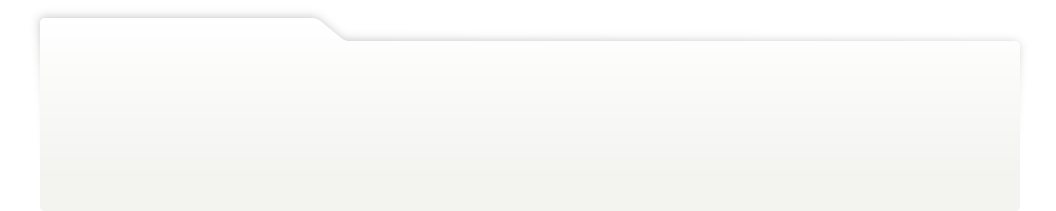
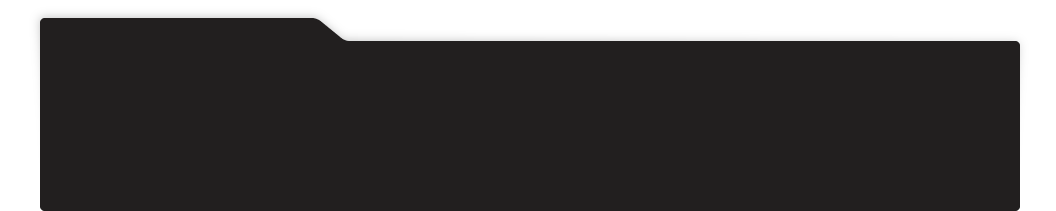
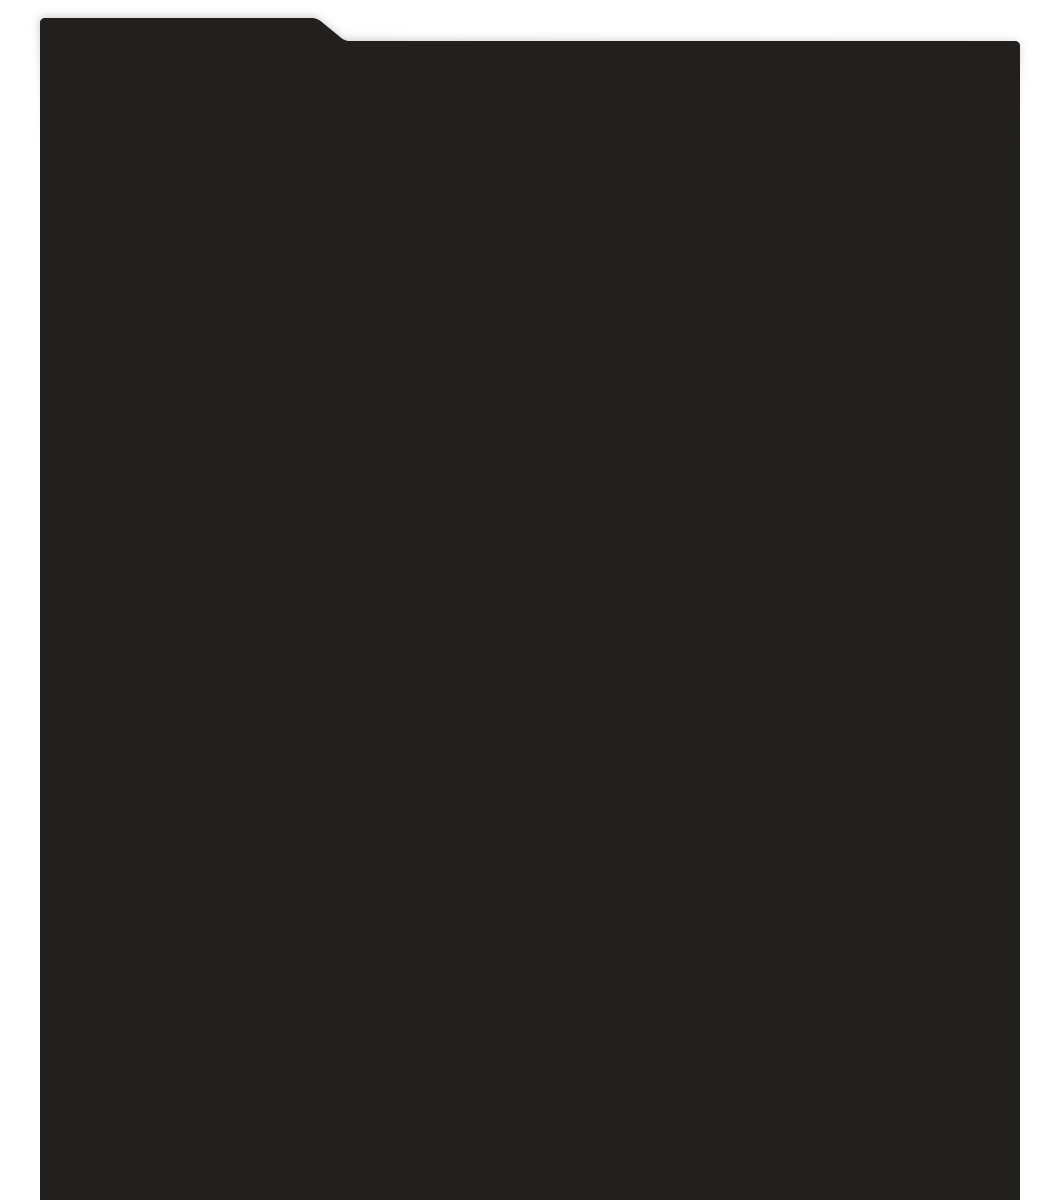
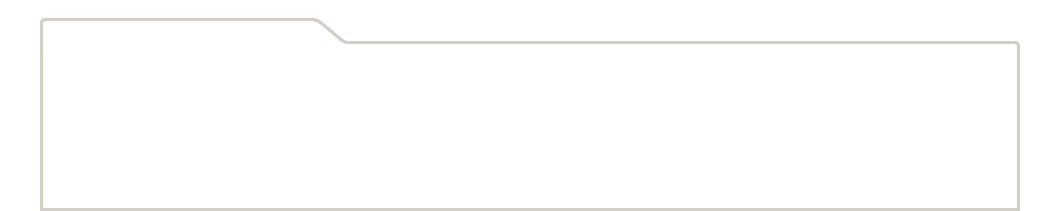
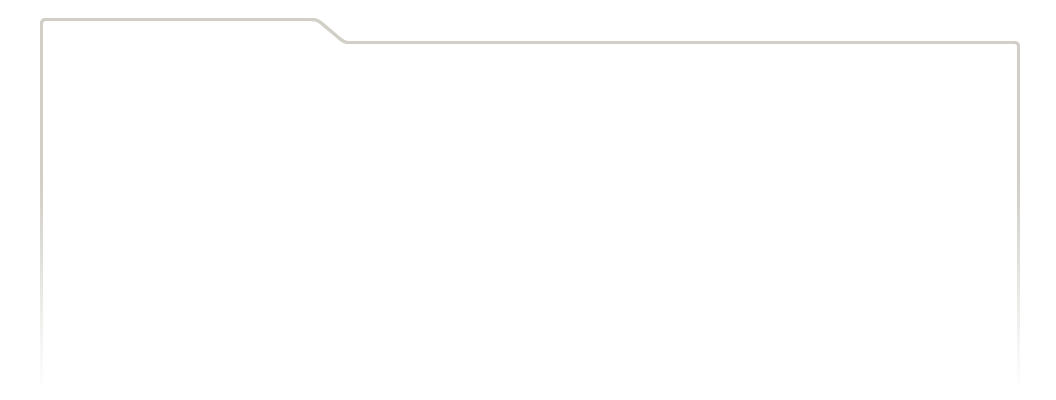
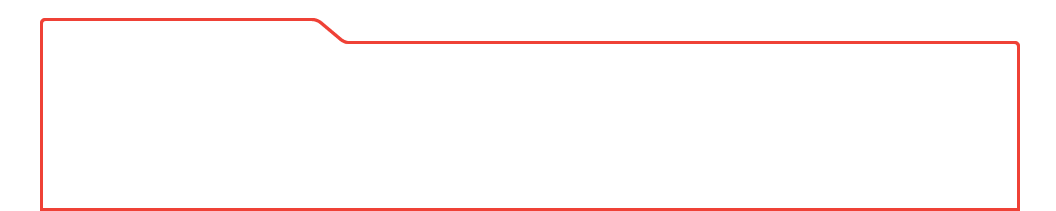
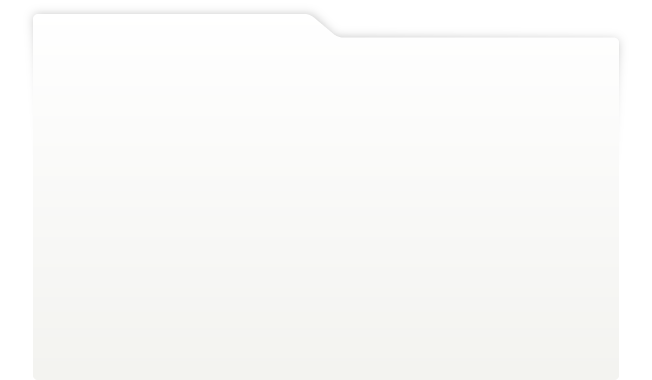
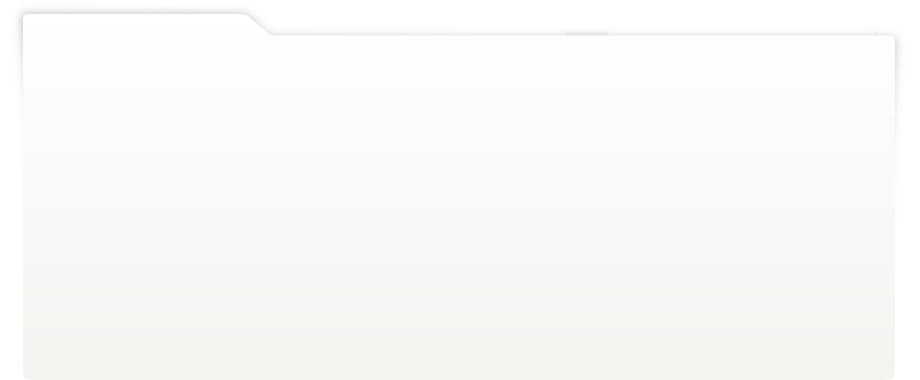
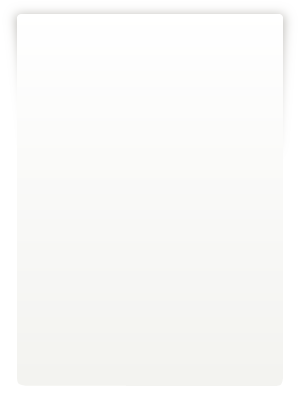
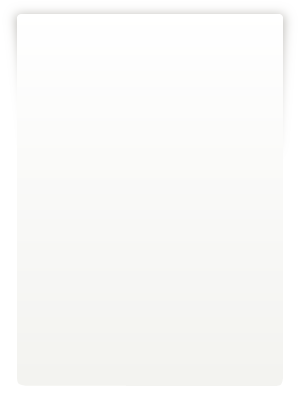
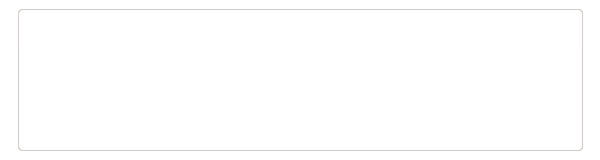
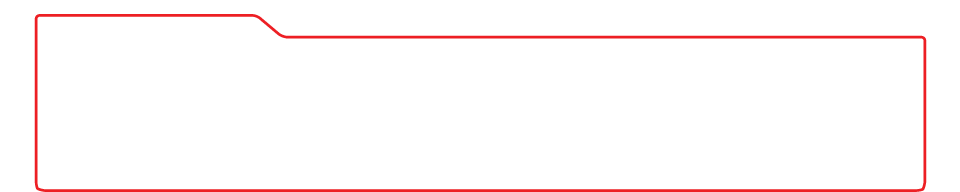
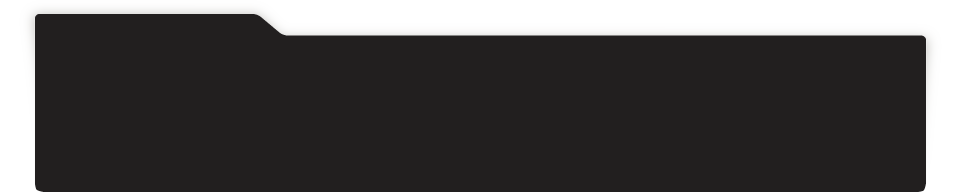
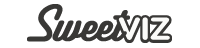
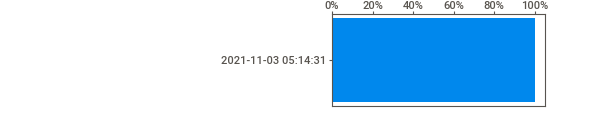
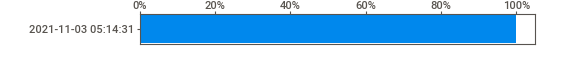
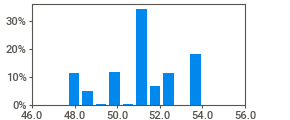
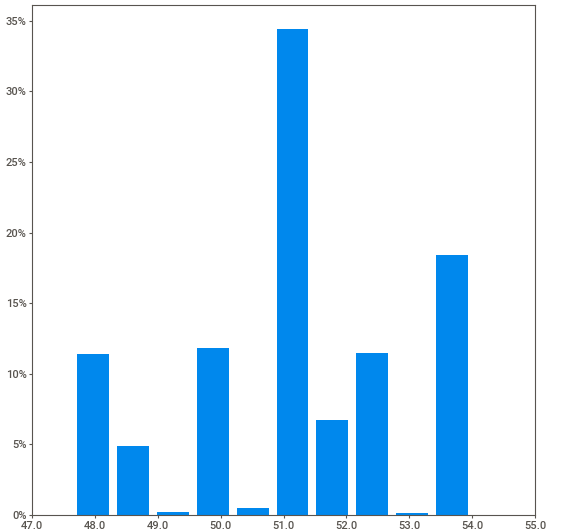
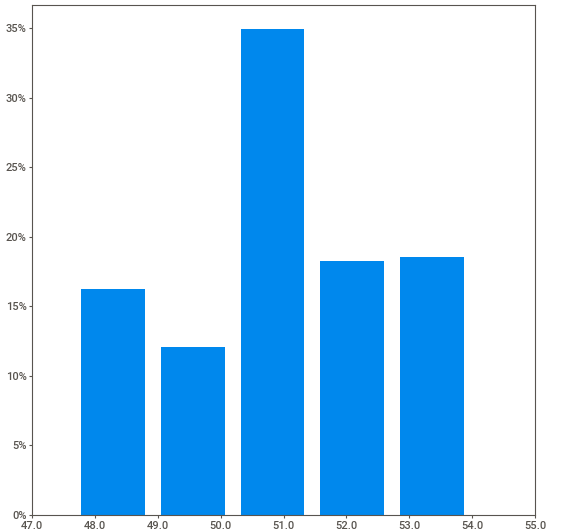
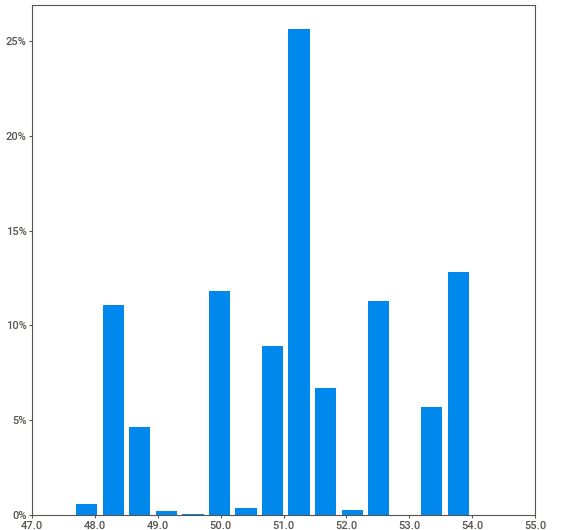
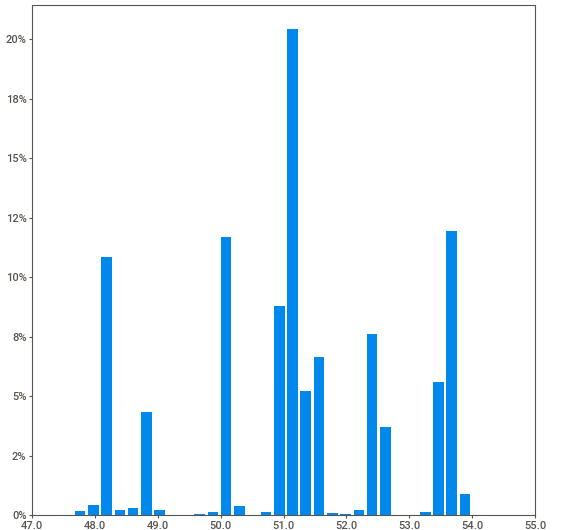
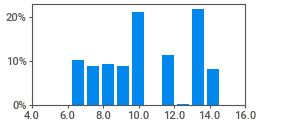
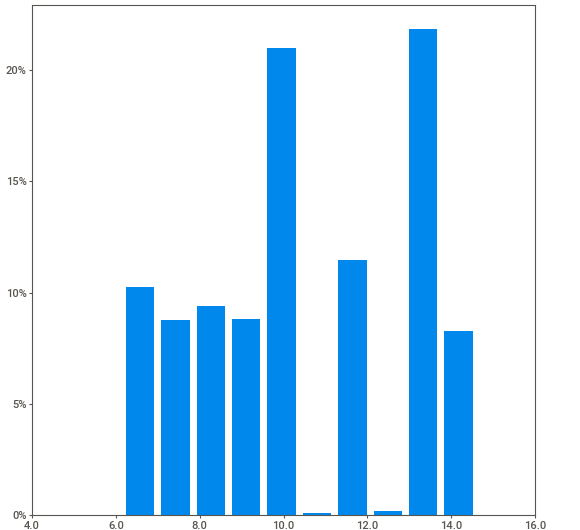
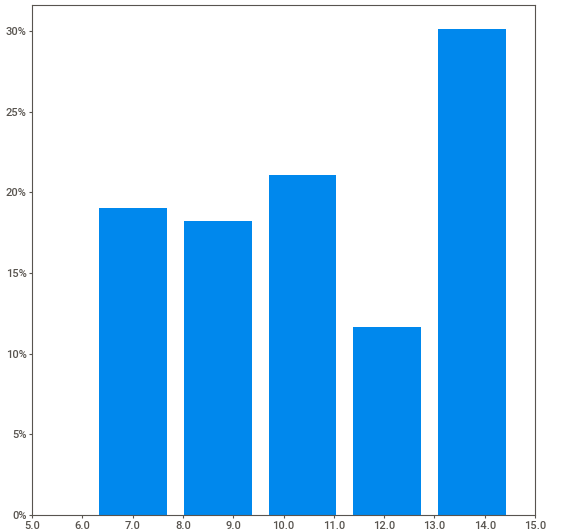
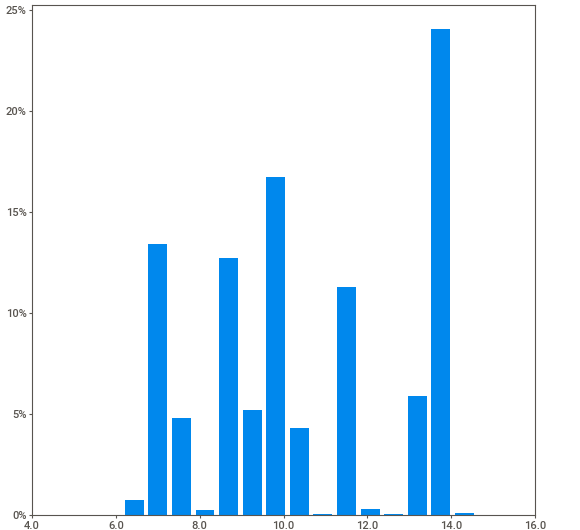
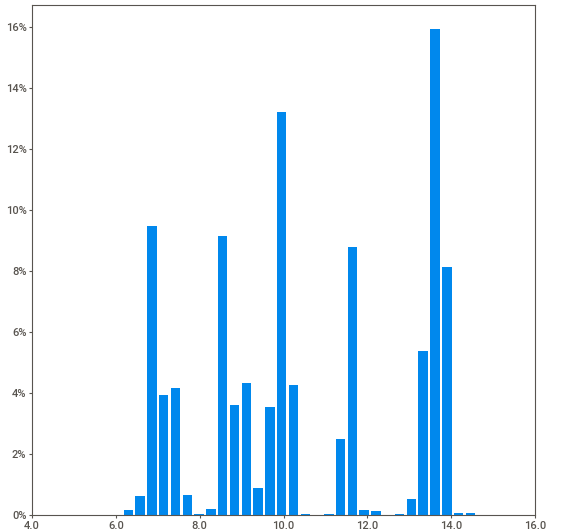
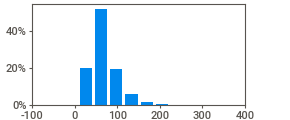
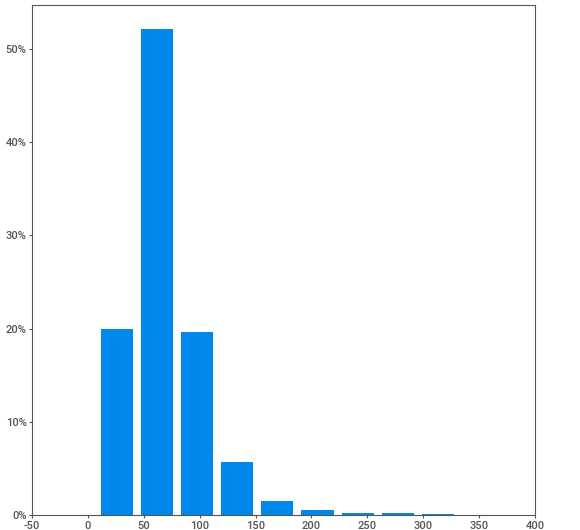
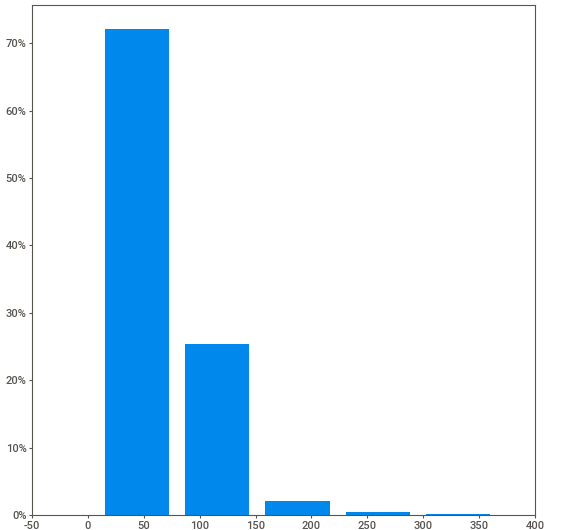
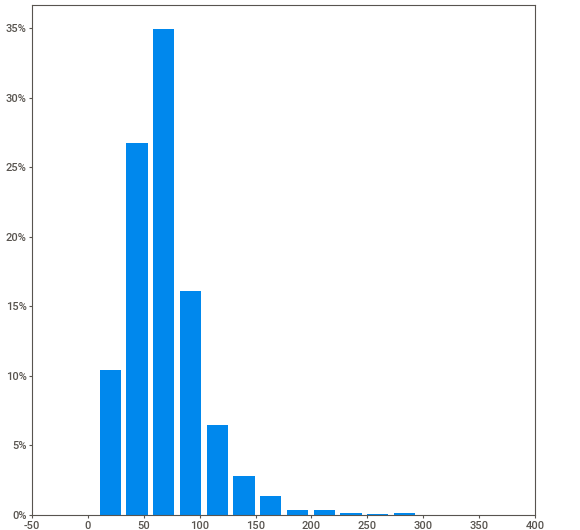
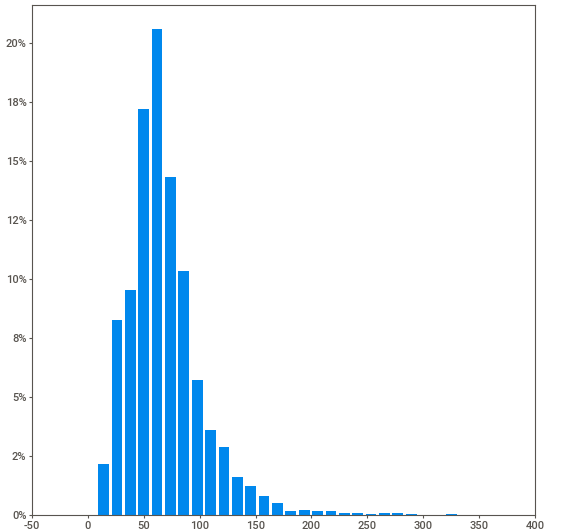
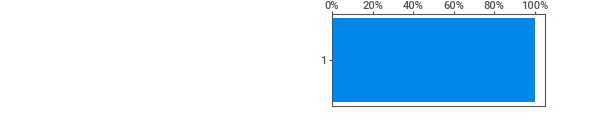
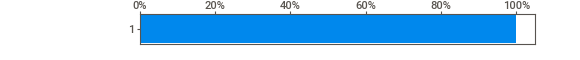
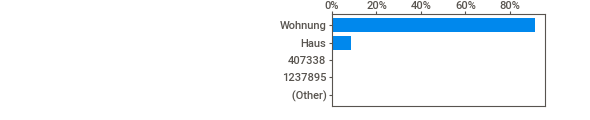
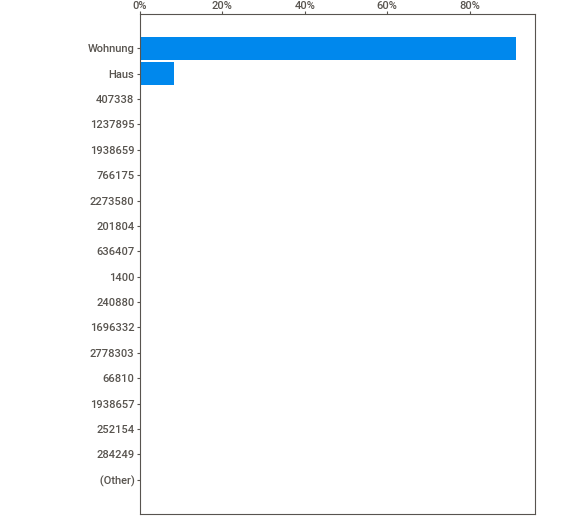
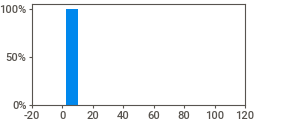
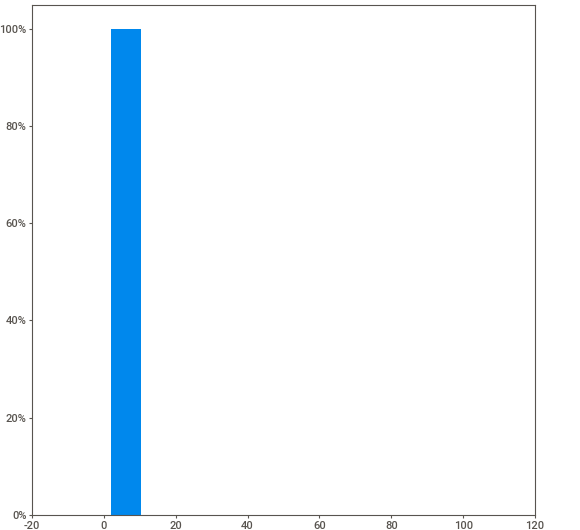
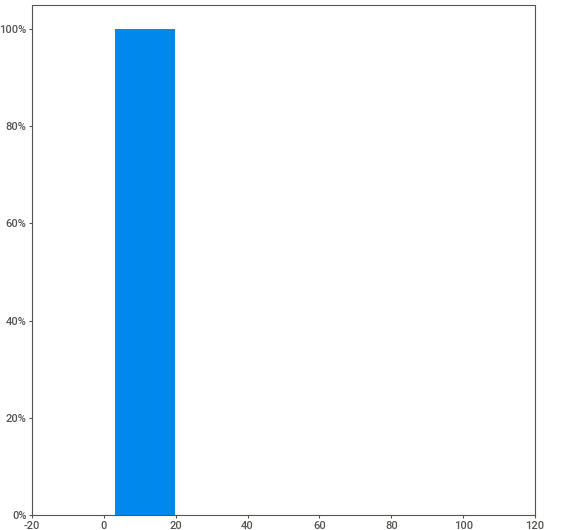
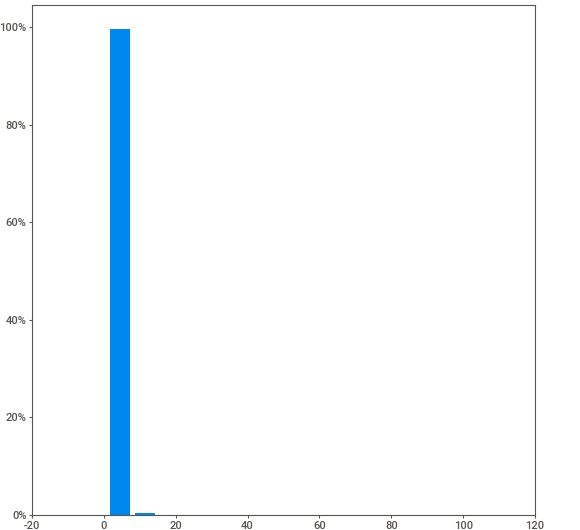
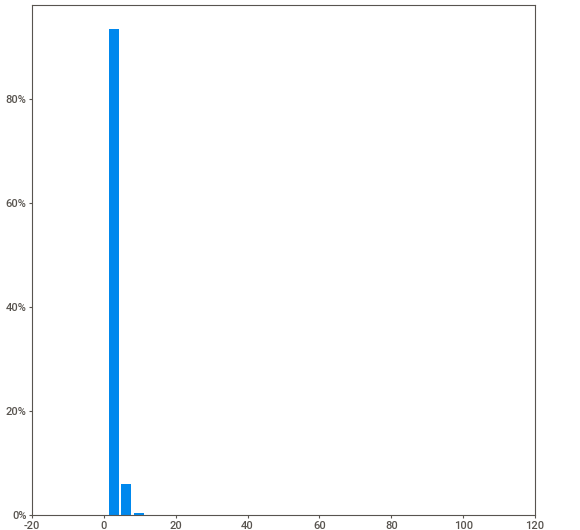
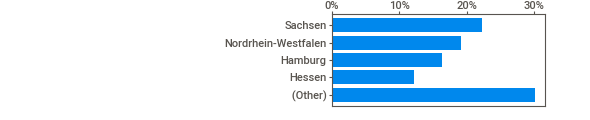
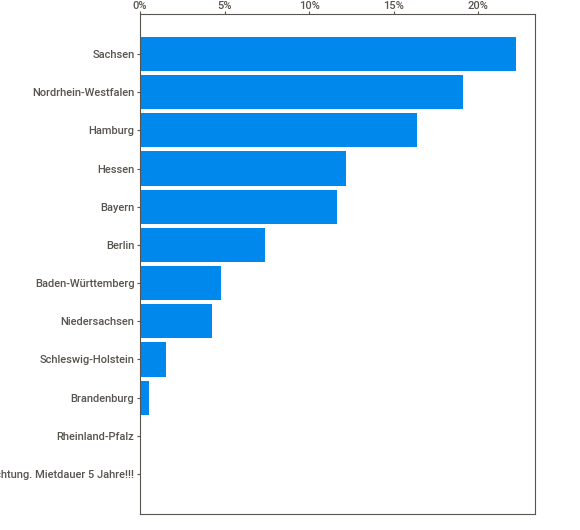
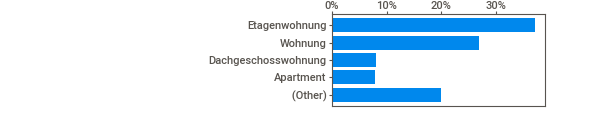
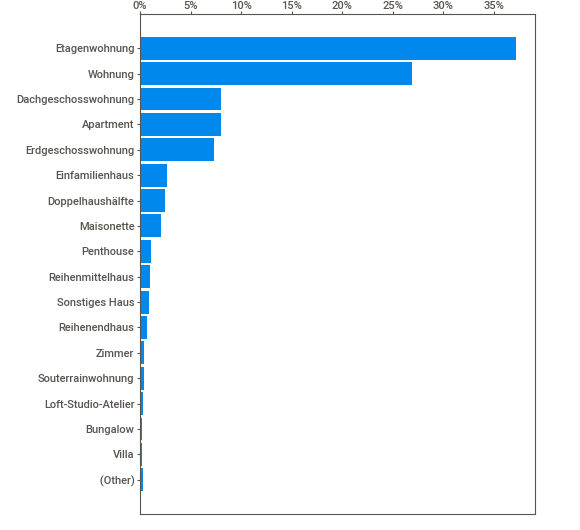
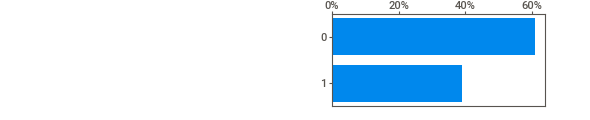
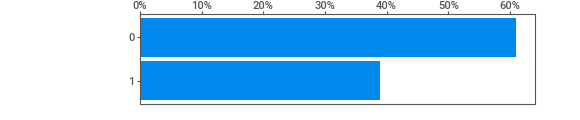
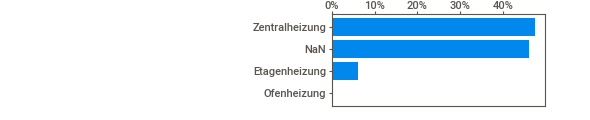
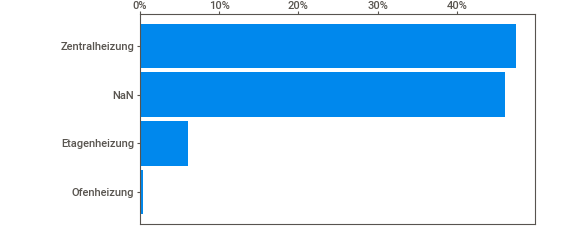
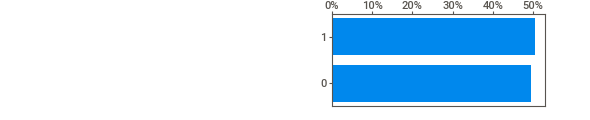
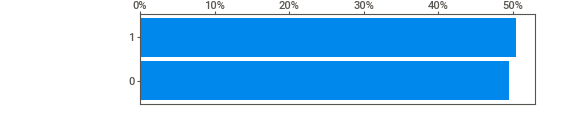
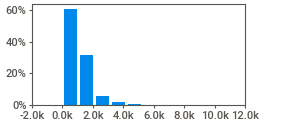
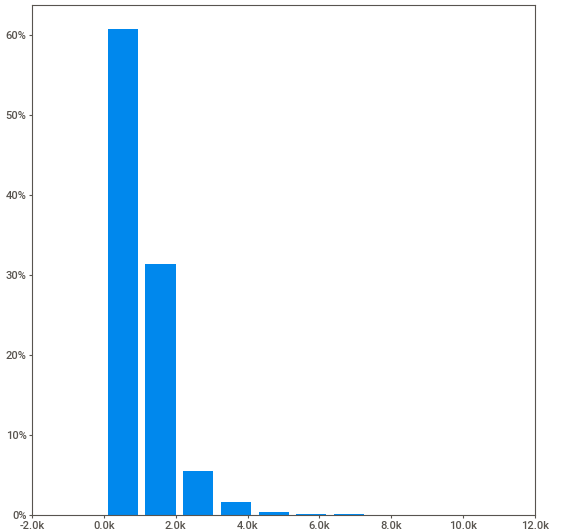
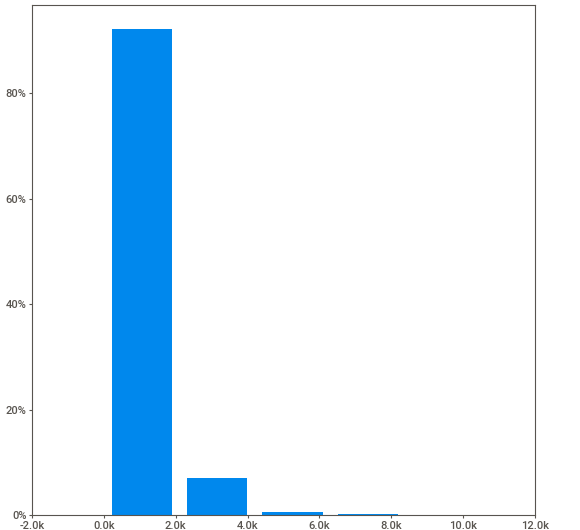
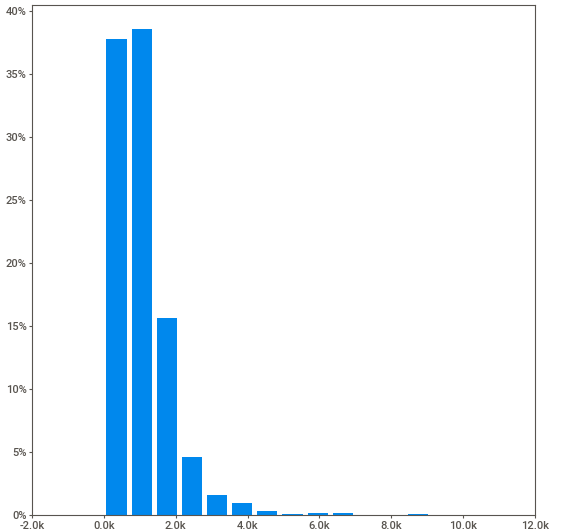
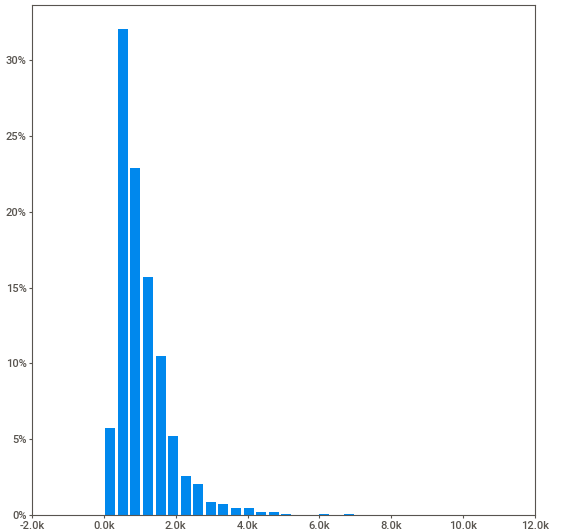
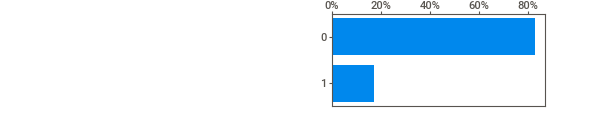
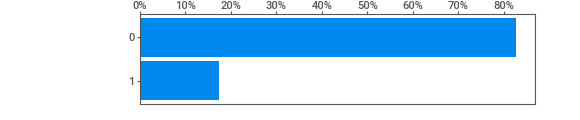
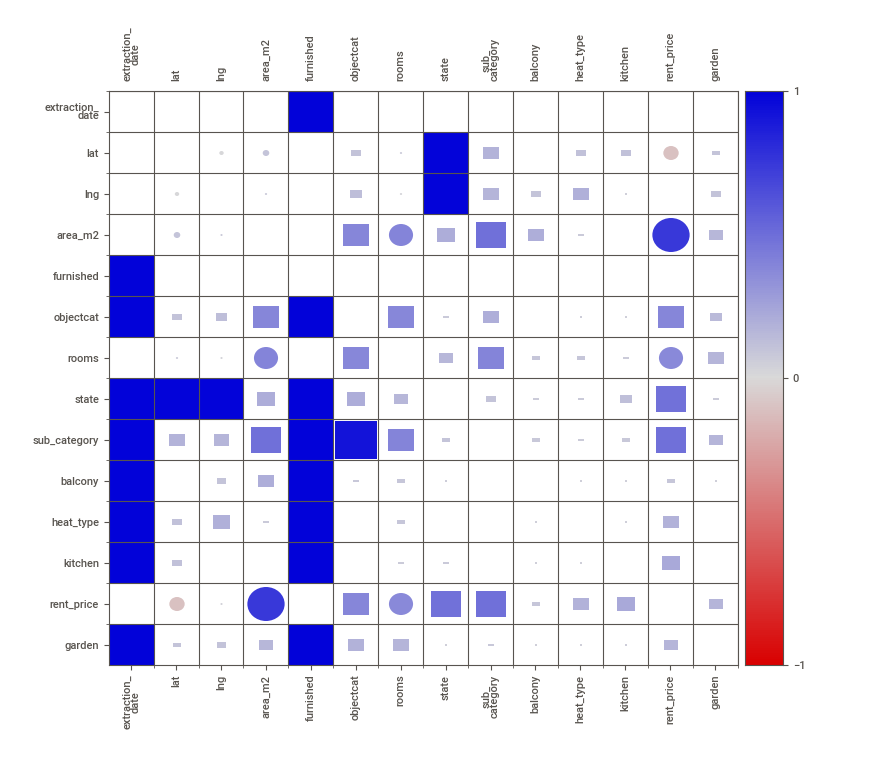
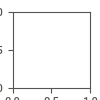

In [21]:
analysis = sv.analyze(df)
analysis.show_notebook()

### Observations 

In [60]:
# offer_id
display(f'Total offers: {len(df["offer_id"].unique())}')
# area_m2
display(f'(area_m2) - Missing values: {round(df.isna().sum()[4]/len(df)*100, 2)} %')
# furnished
display(f'(furnished) - 100% yes(1), need some double check at the extraction and cleaning process.')
# objectcat
dif = len(df) - (len(df[df["objectcat"] == "Wohnung"]) + len(df[df["objectcat"] == "Haus"]))
display('(objectcat) - There are some numerical values and i is wrong. Not "Wohnug" or "Haus": 25')
# rooms
display('(rooms) - Max number of room: 105. Too many rooms, maybe is something wrong here.')
# rent_price
display(f'(rent_price) - Min rent price: €3. I would like to rent this place, need double check.')
display(f'(rent_price) - Max rent price: €10.5K. The 105 rooms house?.')

'Total offers: 6549'

'(area_m2) - Missing values: 7.44 %'

'(furnished) - 100% yes(1), need some double check at the extraction and cleaning process.'

'(objectcat) - There are some numerical values and i is wrong. Not "Wohnug" or "Haus": 25'

'(rooms) - Max number of room: 105. Too many rooms, maybe is something wrong here.'

'(rent_price) - Min rent price: €3. I would like to rent this place, need double check.'

'(rent_price) - Max rent price: €10.5K. The 105 rooms house?.'

## EDA

### Main Hypotheses

1. Offers with larger areas are more expensive.
2. The more rooms, the more expensive.
3. Offers with garten are more expensive.
4. Offers with pre-installed kitchens are more expensive.
5. Offers in old buildings are less expensive.
6. Offers with balcony are more expensive.

In [66]:
df.columns

Index(['offer_id', 'extraction_date', 'lat', 'lng', 'area_m2', 'furnished',
       'zip_code', 'objectcat', 'rooms', 'build_year', 'state', 'city',
       'sub_category', 'balcony', 'heat_type', 'offer_title', 'kitchen',
       'rent_price', 'garden'],
      dtype='object')

#### 1. Offers with larger areas are more expensive.

In [64]:
# Offers with larger areas are more expensive.
# group the areas by a range and compare them by average rent price.

df['area_m2'].describe()

count    6062.000000
mean       68.565163
std        34.242463
min         8.000000
25%        48.000000
50%        63.000000
75%        82.402500
max       367.000000
Name: area_m2, dtype: float64

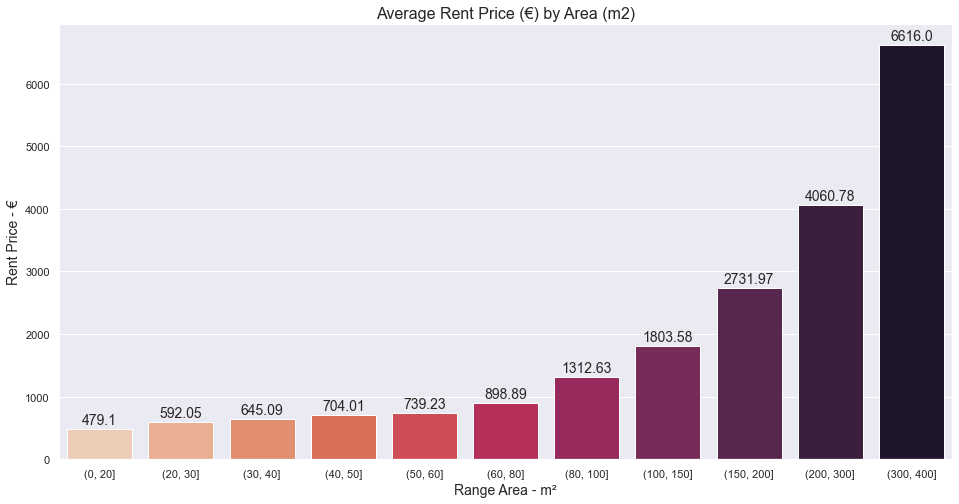

In [134]:
# create a auxiliar dataframe to aggregate the needed infos
df_aux = df[['area_m2', 'rent_price']]
df_aux['range_area'] = pd.cut(df_aux['area_m2'], [0, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300, 400])
df_aux = pd.DataFrame(df_aux.groupby('range_area')['rent_price'].mean().round(2)).reset_index()

# plot the infos
ax = sns.barplot(x=df_aux['range_area'], y=df_aux['rent_price'], palette="rocket_r")
ax.set_title('Average Rent Price (€) by Area (m2)', fontsize=16)
ax.set_ylabel('Rent Price - €', fontsize=14)
ax.set_xlabel('Range Area - m²', fontsize=14)
annot_plot(ax)
plt.savefig('../charts/avg_rent_by_m2.png')

**HYPOTESIS 01 - True**

As expected, offers with larger areas are more expensive, at least when we refer to absolute values.

#### 02. The more rooms, the more expensive.

### Search for insights

- Check average rent price for each city.
- Check price/m2 for each city.
- Check price/m2 for each zip code.
- Check average price per years build.
- Check average price by state.
- Check average price by room.
- Check average price by sub-category.
- Check average price by heat type.